<a href="https://colab.research.google.com/github/whsu2s/vision/blob/main/spleen_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Image Segmentation

## Data Set 

The data set is from the medicaldecathlon challenge here: http://medicaldecathlon.com/.

You can download the images from: https://drive.google.com/drive/folders/1HqEgzS8BV2c7xYNrZdEAnrHk7osJJ--2

Please choose the SPLEEN data set to work with. Use gunzip to extract the images. 

IMPORTANT: You can choose any model you want to solve the task. It is NOT the goal to break the state of the art or invent some super sophisticated architecture, BUT more to show that you are aware of accurate scientific work and preparing and evaluating structured machine learning experiments.  


In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm]"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     |████████████████████████████████| 501kB 9.1MB/s 
     |████████████████████████████████| 81kB 9.1MB/s 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from skimage.transform import resize

import glob, os
import json
import pandas as pd
import time

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim

from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.losses import DiceLoss
from monai.metrics import compute_meandice

from sklearn.model_selection import train_test_split

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
# Mount data from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# List data and labels
filepath = '/content/drive/MyDrive/data/'
train_data = sorted(glob.glob(os.path.join(filepath, 'imagesTr/*.nii.gz')))
train_labels = sorted(glob.glob(os.path.join(filepath, 'labelsTr/*.nii.gz')))
test_data = glob.glob(os.path.join(filepath, 'imagesTs/*.nii.gz'))
print(f'Train data: {len(train_data)}, train labels: {len(train_labels)}, test data: {len(test_data)}')

# Ensure training data have corresponding labels
data_idx = [os.path.basename(f).split('.')[0] for f in train_data]
label_idx = [os.path.basename(f).split('.')[0] for f in train_labels]
assert set(data_idx) == set(label_idx)

Train data: 41, train labels: 41, test data: 20


In [ ]:
# Collect information regarding labels
fnames = []
volumes = []
num_slices = []
num_roi = []
first_non_zero_slices = []
last_non_zero_slices = []
non_zero_perc = []

for f in train_labels:
    fnames.append(os.path.basename(f.split('.')[0]))
    img = nib.load(f).get_fdata()
    volumes.append(np.sum(img == 1) / 1000)  # volume in cm^3

    depth = img.shape[2]
    num_slices.append(depth)  # number of slices
    slices = [np.count_nonzero(img[:,:,i]) > 0 for i in range(depth)]
    num_roi.append(sum(slices))  # number of slices with foreground

    non_zero_slices = [i for i, x in enumerate(slices) if x]
    first_non_zero_slices.append(non_zero_slices[0])
    last_non_zero_slices.append(non_zero_slices[-1])
    non_zero_perc.append(len(non_zero_slices) / depth)

# Create dataframe
d = {'file': fnames, 'num_slices': num_slices, 'num_roi': num_roi, \
     'from_slice': first_non_zero_slices, 'to_slice': last_non_zero_slices, \
     'percentage': non_zero_perc, 'volume': volumes}
label_df = pd.DataFrame(data=d)
#label_df.to_csv('label_info.csv', index=False)

In [ ]:
label_df.head()

,file,num_slices,num_roi,from_slice,to_slice,percentage,volume
0,spleen_10,55,17,23,39,0.309091,53.071
1,spleen_12,168,80,62,141,0.476190,537.685
2,spleen_13,77,40,26,65,0.519481,203.903
3,spleen_14,54,21,23,43,0.388889,124.163
4,spleen_16,61,11,39,49,0.180328,40.044


In [ ]:
print('Mean number of slices: %.3f' % label_df['num_slices'].mean())
print('Mean starting slice index with annotation: %.3f' % label_df['from_slice'].mean())
print('Mean ending slice index with annotation: %.3f' % label_df['to_slice'].mean())
print('Mean number of annotated slices: %.3f' % label_df['num_roi'].mean())
print('Mean percentage of annotation: %.3f' % label_df['percentage'].mean())
print('Mean volume of spleen: %.3f' % label_df['volume'].mean(), 'cm^3')

Mean number of slices: 89.024
Mean starting slice index with annotation: 48.927
Mean ending slice index with annotation: 73.561
Mean number of annotated slices: 25.634
Mean percentage of annotation: 0.299
Mean volume of spleen: 102.172 cm^3


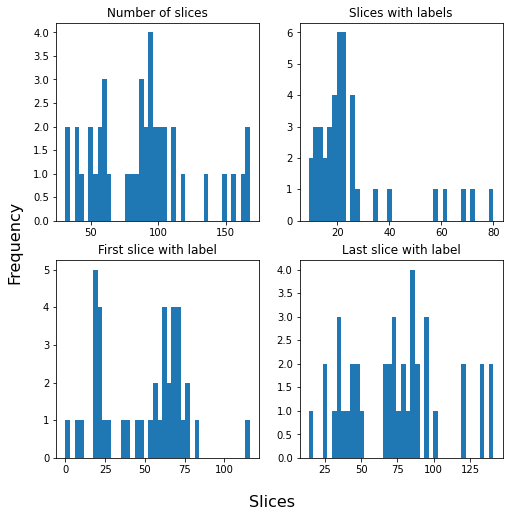

In [ ]:
# Plot histograms of data info
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs[0, 0].hist(label_df['num_slices'], bins=40)
axs[0, 0].set_title('Number of slices')
axs[0, 1].hist(label_df['num_roi'], bins=40)
axs[0, 1].set_title('Slices with labels')
axs[1, 0].hist(label_df['from_slice'], bins=40)
axs[1, 0].set_title('First slice with label')
axs[1, 1].hist(label_df['to_slice'], bins=40)
axs[1, 1].set_title('Last slice with label')
fig.text(0.5, 0.04, 'Slices', ha='center', fontsize=16)
fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical', fontsize=16)
plt.show()

1    spleen_12
Name: file, dtype: object


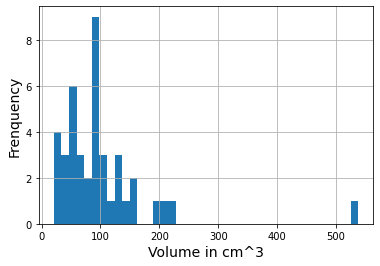

In [ ]:
# Spleen volume distribution
label_df['volume'].hist(bins=40)
plt.xlabel('Volume in cm^3', fontsize=14)
plt.ylabel('Frenquency', fontsize=14)
print(label_df.loc[label_df['volume'] > 300, 'file'])  # outlier

According to the paper "Determination of normal splenic volume on computed tomography in relation to age, gender and body habitus" by Prassopoulos P. et al., a normal spleen has a mean volume of
214.6 cm3 with a range from 107.2 to 314.5 cm3 in the study. Since the dataset was obtained from patients, we may assume that their had shrinked spleen. However, the one ('spleen_12') with a much larger volume should be considered as outlier. The images below show that there might be some duplicated images. As the task is segmentation, this data sample can still be used.





In [ ]:
# There seems to be no header info
nib.load(os.path.join(filepath, 'imagesTr/spleen_12.nii.gz')).header

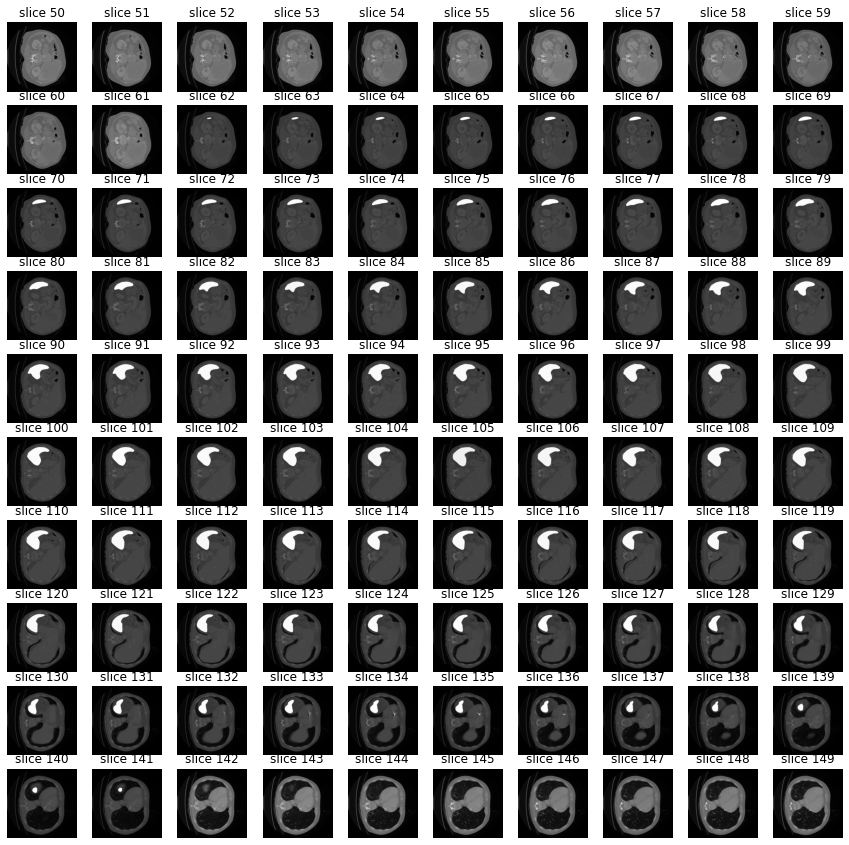

In [ ]:
# Take a look at the outlier with large spleen volume
img = nib.load(os.path.join(filepath, 'imagesTr/spleen_12.nii.gz')).get_fdata()
label = nib.load(os.path.join(filepath, 'labelsTr/spleen_12.nii.gz')).get_fdata()
fig, ax = plt.subplots(10, 10, figsize=(15, 15))
for i in range(100):
    plt_x = i % 10
    plt_y = i // 10
    ax[plt_y, plt_x].imshow(img[..., i+50] + 3000*label[..., i+50], cmap='gray')
    ax[plt_y, plt_x].set_title(f'slice {i+50}')
    ax[plt_y, plt_x].axis('off')
plt.show() 

## Preprocessing


In [ ]:
# Dataset to read images and labels
class CTDataset(Dataset):
    def __init__(self, root_dir, data_file='dataset.json', depth=100, mode='train', transform=None):
        """
        Args:
            root_dir (string): directory with all the data
            data_file (string): json file of dataset
            depth (int): number of CT slices 
            mode (string): 'train' or 'test'
            transform (object): Rescale(), Normalize(), Crop() 
        """
        self.root_dir = root_dir
        self.data_file = data_file
        self.depth = depth
        self.mode = mode
        self.transform = transform
        self.data = self._read_json(os.path.join(root_dir, self.data_file))
        if self.mode == 'train':
            self.dataset = self.data['training']
        elif self.mode == 'test':
            self.dataset = self.data['test']
        else:
            print('No such mode.')

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if self.mode == 'train':
            image = nib.load(os.path.join(self.root_dir, self.dataset[idx]['image'])).get_fdata()
            image = torch.tensor(image, dtype=torch.float32)
            label = nib.load(os.path.join(self.root_dir, self.dataset[idx]['label'])).get_fdata()
            label = torch.tensor(label)
            file_name = os.path.basename(self.dataset[idx]['image'])
            # Pad or crop image and label in depth
            image, label = self._pad_crop(image, label)
            sample = {'image': image, 'label': label, 'filename': file_name}
        elif self.mode == 'test':
            image = nib.load(os.path.join(self.root_dir, self.dataset[idx])).get_fdata()
            image = torch.tensor(image, dtype=torch.float32) 
            file_name = os.path.basename(self.dataset[idx])
            sample = {'image': image, 'filename': file_name}
        if self.transform is not None:
            sample = self.transform(sample)

        return sample

    def _read_json(self, fpath):
        with open(fpath, 'r') as f:
            return json.load(f)

    def _pad_crop(self, image, label):
        d = image.shape[2]
        # Crop
        if self.depth < d:  
            new_image = image[..., -self.depth:]
            new_label = label[..., -self.depth:]
        # Pad
        elif self.depth > d:  
            n = self.depth // d
            res = self.depth % d
            new_image = torch.cat([torch.zeros(image.shape[0], image.shape[1], self.depth-d), image], dim=2)
            new_label = torch.cat([torch.zeros(label.shape[0], label.shape[1], self.depth-d), label], dim=2)  
        else:
            new_image = image
            new_label = label

        return new_image, new_label


In [ ]:
# Customed transform class to handle dict object
class Rescale(object):
    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, sample):
        image, label, file_name = sample['image'], sample['label'], sample['filename']
        h, w, d = image.shape 
        new_h, new_w = self.output_size, self.output_size
        new_image = resize(image, (new_h, new_w, d))
        new_label = resize(label, (new_h, new_w, d))

        return {'image': new_image, 'label': new_label, 'filename': file_name}

class Normalize(object):
    def __call__(self, sample):
        image, label, file_name = sample['image'], sample['label'], sample['filename']

        return {'image': self._normalize(image), 'label': label, 'filename': file_name}
        
    def _normalize(self, img):
        img_min = img.min(axis=(0, 1), keepdims=True)
        img_max = img.max(axis=(0, 1), keepdims=True)
        num = img - img_min
        den = img_max - img_min
        new_img = np.divide(num, den, out=np.zeros_like(num), where=den!=0)  # Ignore slices with all zeros
        return new_img 

class Crop(object):
    def __init__(self, r):  # r (int): crop size for width and height
        self.r = r

    def __call__(self, sample):
        image, label, file_name = sample['image'], sample['label'], sample['filename']
        w0 = image.shape[1] 
        start = 0.2
        new_image = image[:self.r, int(start*w0):int(start*w0)+self.r, :]  # Crop around the spleen
        new_label = label[:self.r, int(start*w0):int(start*w0)+self.r, :]

        return {'image': new_image, 'label': new_label, 'filename': file_name}

In [ ]:
## prepare a pytorch data loader here 
dataset = CTDataset(filepath, data_file='dataset.json', depth=96,
                    transform=transforms.Compose([Rescale(256), 
                                                  Normalize() 
                                                  ]))  # Crop(128)
print(dataset[0]['image'].shape, np.max(dataset[0]['image']), np.max(dataset[0]['label']))
print(len(train_data), len(test_data))

idx = range(len(dataset))
X_train, X_val = train_test_split(dataset, test_size=0.4, random_state=1, shuffle=True)
X_val, X_test = train_test_split(X_val, test_size=0.5, random_state=1, shuffle=True)

dataloader = {
    'train': DataLoader(dataset=X_train, batch_size=2, shuffle=True),
    'val': DataLoader(dataset=X_val, batch_size=2, shuffle=True),
    'test': DataLoader(dataset=X_test, batch_size=1, shuffle=True)
}
print(len(dataloader['train'].dataset), len(dataloader['val'].dataset), len(dataloader['test'].dataset))

(256, 256, 96) 1.0 1.0
41 20
24 8 9


In [ ]:
for i, data in enumerate(dataloader['train']):
    print(i, data['filename'])

0 ['spleen_44.nii.gz', 'spleen_16.nii.gz']
1 ['spleen_21.nii.gz', 'spleen_25.nii.gz']
2 ['spleen_27.nii.gz', 'spleen_10.nii.gz']
3 ['spleen_20.nii.gz', 'spleen_56.nii.gz']
4 ['spleen_62.nii.gz', 'spleen_61.nii.gz']
5 ['spleen_9.nii.gz', 'spleen_26.nii.gz']
6 ['spleen_19.nii.gz', 'spleen_32.nii.gz']
7 ['spleen_3.nii.gz', 'spleen_2.nii.gz']
8 ['spleen_41.nii.gz', 'spleen_13.nii.gz']
9 ['spleen_31.nii.gz', 'spleen_46.nii.gz']
10 ['spleen_29.nii.gz', 'spleen_17.nii.gz']
11 ['spleen_38.nii.gz', 'spleen_33.nii.gz']


In [ ]:
for i, data in enumerate(dataloader['val']):
    print(i, data['filename'])

0 ['spleen_14.nii.gz', 'spleen_24.nii.gz']
1 ['spleen_63.nii.gz', 'spleen_49.nii.gz']
2 ['spleen_59.nii.gz', 'spleen_12.nii.gz']
3 ['spleen_47.nii.gz', 'spleen_40.nii.gz']


In [ ]:
del X_train, X_val, X_test

In [ ]:
# Plot labels on the images 
def show_slices(img, label, w, h):
    """
    Args:
        img (array): image
        label (array): label
        w (int): plot width 
        h (int): plot height
    """
    fig, ax = plt.subplots(h, w, figsize=(15, 15))
    for i in range(w*h):
        plt_x = i % w
        plt_y = i // w
        if (i < img.shape[-1]):
            ax[plt_y, plt_x].imshow(img[..., i] + label[..., i], cmap='gray')
            ax[plt_y, plt_x].set_title(f'slice {i}')
        ax[plt_y, plt_x].axis('off')
    plt.show()    

spleen_46.nii.gz


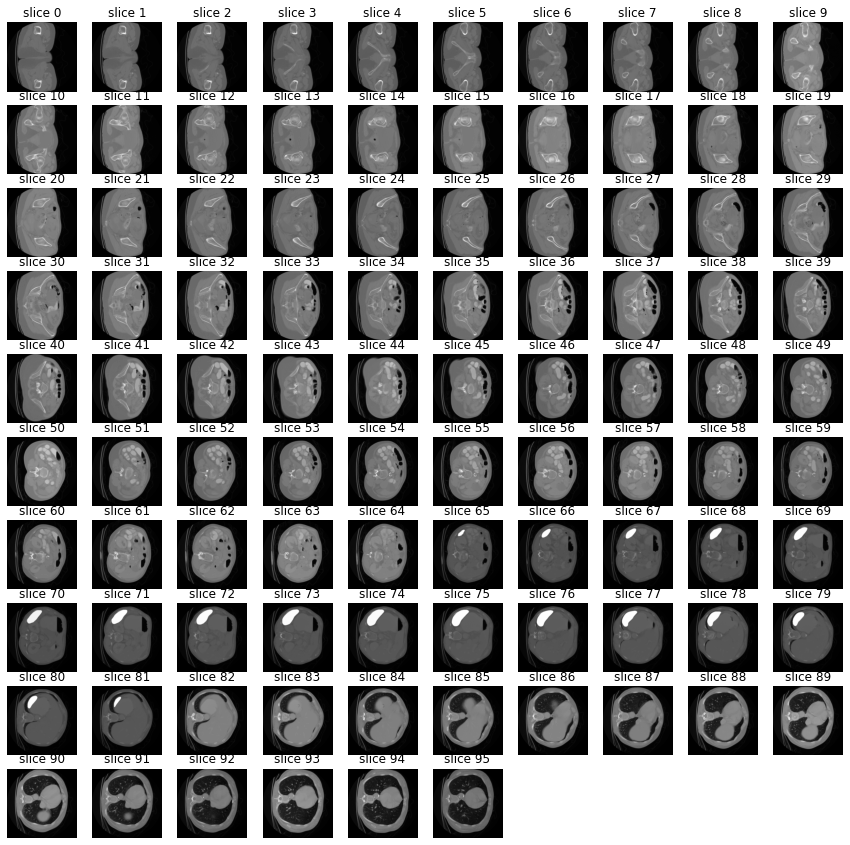

Image: shape: (256, 256, 96), dynamic range: (0.0, 1.0)
Label: shape: (256, 256, 96), dynamic range: (0.0, 1.0)


In [ ]:
# The first training CT volume
n = 2
image = dataloader['train'].dataset[n]['image']
label = dataloader['train'].dataset[n]['label']
print(dataloader['train'].dataset[n]['filename'])
show_slices(image, label, 10, 10)
print(f'Image: shape: {image.shape}, dynamic range: ({np.min(image)}, {np.max(image)})')
print(f'Label: shape: {label.shape}, dynamic range: ({np.min(label)}, {np.max(label)})')

## Model


In [ ]:
# Initialize U-Net from monai
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
#print(model)

In [ ]:
print(sum(p.numel() for p in model.parameters() if p.requires_grad), 'trainable parameters.')

4808917 trainable parameters.


In [ ]:
import torchsummary
torchsummary.summary(model, input_size=(1, 128, 128, 96))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 16, 64, 64, 48]             448
            Conv3d-2       [-1, 16, 64, 64, 48]             448
       BatchNorm3d-3       [-1, 16, 64, 64, 48]              32
           Dropout-4       [-1, 16, 64, 64, 48]               0
             PReLU-5       [-1, 16, 64, 64, 48]               1
            Conv3d-6       [-1, 16, 64, 64, 48]           6,928
       BatchNorm3d-7       [-1, 16, 64, 64, 48]              32
           Dropout-8       [-1, 16, 64, 64, 48]               0
             PReLU-9       [-1, 16, 64, 64, 48]               1
     ResidualUnit-10       [-1, 16, 64, 64, 48]               0
           Conv3d-11       [-1, 32, 32, 32, 24]          13,856
           Conv3d-12       [-1, 32, 32, 32, 24]          13,856
      BatchNorm3d-13       [-1, 32, 32, 32, 24]              64
          Dropout-14       [-1, 32, 32,

## Training

In [ ]:
# Custom loss function: cross entropy and dice coefficient
class DLoss(nn.Module):
    def __init__(self):
        super(DLoss, self).__init__()

    def forward(self, pred, target):
        ce_loss = nn.CrossEntropyLoss()(pred, target)

        pred = torch.argmax(pred, dim=1).view(-1)
        target = target.view(-1)
        smooth = 1e-10

        # Dice Loss
        dice_coef = (2.0 * (pred.double() * target.double()).sum()) / \
        (pred.double().sum() + target.double().sum() + smooth)
        dice_coef = dice_coef.clone().detach().requires_grad_(True)

        return 0.8*(1 - dice_coef) + 0.2*ce_loss

# Calculate dice coefficient for a batch
def batch_dice(pred, label):
    smooth = 1e-10
    m1 = torch.argmax(pred, dim=1).cpu().detach().numpy() #keepdim=True
    m2 = label.cpu().detach().numpy()
    intersection = np.sum((m1 * m2) > 0)  #(m1 * m2).sum() 
    total = np.sum(m1 > 0) + np.sum(m2 > 0)  #m1.sum() + m2.sum()

    return (2. * intersection) / (total + smooth)



In [ ]:
# Hyperparametes
num_epochs = 200
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) 
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
#loss_function = nn.CrossEntropyLoss()  #DLoss() # 
loss_function = DiceLoss(to_onehot_y=True, softmax=True)


In [ ]:
# Training loop
%%time
train_loss = []
val_loss = []
train_dice = []
val_dice = []
best_dice_epoch = 0
best_dice = 0.0
dice = dict.fromkeys(['train', 'val'])

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)


    since = time.time()
    
    for phase in ['train', 'val']:
        epoch_loss = 0.0
        dice_coeff = []
        if phase == 'train':
            model.train()
        else:
            model.eval()           

        for data in dataloader[phase]:
            images = data['image'].unsqueeze(1).to(device) # model expects 5d tensor: (batch, c', h, w, c)
            labels = data['label'].unsqueeze(1).to(device)

            optimizer.zero_grad() 

            with torch.set_grad_enabled(phase=='train'):                                    
                outputs = model(images)  # shape: [batch,2,h,w,c] 
                loss = loss_function(outputs, labels)
                epoch_loss += loss.item()
                #preds = torch.argmax(outputs, dim=1).squeeze(1)
                #print("Train dice: ", compute_meandice(preds, labels.squeeze(1)).sum().item())
                #print("Shape: ", labels.shape, outputs.shape)
                #print("Dice: ", batch_dice(outputs, labels))
                dice_coeff.append(batch_dice(outputs, labels))  # Dice coefficeint for batch of slice
    
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

        epoch_loss = epoch_loss / len(dataloader[phase].dataset)
              
        if phase == 'train':
            train_loss.append(epoch_loss) 
            dice['train'] = sum(dice_coeff) / len(dice_coeff)
            train_dice.append(dice['train'])
        else:
            val_loss.append(epoch_loss)
            dice['val'] = sum(dice_coeff) / len(dice_coeff)
            val_dice.append(dice['val'])
            if dice['val'] > best_dice:
                best_dice = dice['val']
                best_dice_epoch = epoch
                #torch.save(model.state_dict(), "best_model.pth"))
                #print("saved best model")
        print(f'{phase} loss: {epoch_loss:.4f}, dice: {dice[phase]:.4f}')

    time_elapsed = time.time() - since
    print(f'{time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        

Epoch 0/199
----------
train loss: 0.3315, dice: 0.0196
val loss: 0.3343, dice: 0.0296
0m 40s
Epoch 1/199
----------
train loss: 0.3231, dice: 0.0234
val loss: 0.3249, dice: 0.0345
0m 40s
Epoch 2/199
----------
train loss: 0.3180, dice: 0.0233
val loss: 0.3166, dice: 0.0414
0m 40s
Epoch 3/199
----------
train loss: 0.3140, dice: 0.0262
val loss: 0.3123, dice: 0.0417
0m 40s
Epoch 4/199
----------
train loss: 0.3108, dice: 0.0265
val loss: 0.3099, dice: 0.0440
0m 40s
Epoch 5/199
----------
train loss: 0.3081, dice: 0.0296
val loss: 0.3079, dice: 0.0480
0m 40s
Epoch 6/199
----------
train loss: 0.3061, dice: 0.0301
val loss: 0.3055, dice: 0.0475
0m 40s
Epoch 7/199
----------
train loss: 0.3038, dice: 0.0309
val loss: 0.3033, dice: 0.0543
0m 40s
Epoch 8/199
----------
train loss: 0.3017, dice: 0.0327
val loss: 0.3006, dice: 0.0506
0m 40s
Epoch 9/199
----------
train loss: 0.3000, dice: 0.0350
val loss: 0.2979, dice: 0.0560
0m 40s
Epoch 10/199
----------
train loss: 0.2983, dice: 0.0411
val

KeyboardInterrupt: ignored

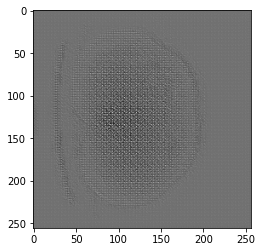

In [ ]:
pred = outputs[0].cpu().detach().numpy()
plt.imshow(pred[0,:,:,50])
plt.show()

In [ ]:
pred[0,:,:,50].max()

6.887996

In [ ]:
print(best_dice_epoch, best_dice)

60 tensor(0.8676)


In [ ]:
dice['train']

tensor(1.0443)

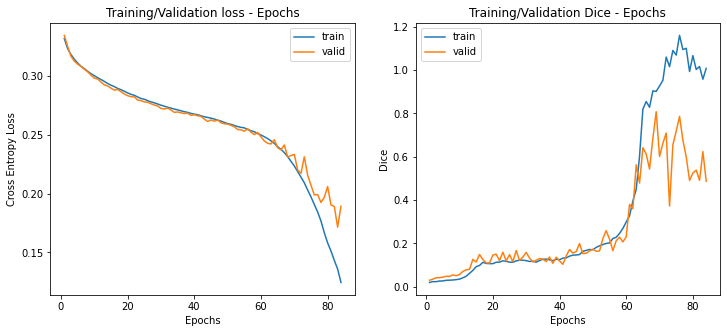

In [ ]:
# Learning curve
num_epochs = len(train_loss)

plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.title('Training/Validation loss - Epochs')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.plot(range(1, num_epochs+1), train_loss, label='train')
plt.plot(range(1, num_epochs+1), val_loss, label='valid')
#plt.xticks(np.arange(0, num_epochs+1, 5.0))
plt.legend()

plt.subplot(1,2,2)
plt.title('Training/Validation Dice - Epochs')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.plot(range(1, num_epochs+1), train_dice, label='train')
plt.plot(range(1, num_epochs+1), val_dice, label='valid')
#plt.xticks(np.arange(0, num_epochs+1, 5.0))
plt.legend()
plt.show()

In [ ]:
torch.save(model.state_dict(), 'model.pth')

In [ ]:
# Load model
model = UNet(in_channels=1, out_channels=2, init_features=64) 
model.load_state_dict(torch.load('model.pth'))
model.to(device)

## Evaluation

In [ ]:
# Evaluation metrics
def dice3d(a, b, smooth=1e-10):
    """
    Compute the dice similarity coefficient for two 3D volumes.

    Arguments:
        a (numpy array): 3D array 
        b (numpy array): 3D array 
        smooth (float): small number to avoid division by 0
    Returns:
        dice coefficient (float)
    """
    a = a.cpu().detach().numpy()
    b = b.cpu().detach().numpy()
    intersection = np.sum((a * b) > 0)
    volumes = np.sum(a > 0) + np.sum(b > 0)

    return 2 * float(intersection) / (volumes + smooth) 

def precision(label, pred):
    tp = (label[label==pred]).sum()
    fn = (label[label!=pred]).sum()

    return tp / (tp + fn)

def recall(label, pred):
    tp = (label[label==pred]).sum()
    fp = (pred[pred!=label]).sum()

    return tp / (tp + fp)    

In [ ]:
## evaluate your model on the test set here
model.eval()
torch.no_grad()
total_loss = 0.0
dice_list = []
precision_list = []
recall_list = []

for i, data in enumerate(dataloader['test'].dataset):
    image = torch.from_numpy(data['image']).unsqueeze(0).unsqueeze(0).to(device)
    label = torch.from_numpy(data['label']).long()
    #pred_label = torch.zeros(image.shape)

    pred = model(image).squeeze(0).cpu().detach()
    pred_label = torch.argmax(pred, dim=0)

    dice_list.append(dice3d(label, pred_label))
    precision_list.append(precision(label, pred_label))
    recall_list.append(recall(label, pred_label))

    print(f'Dice score: {dice_list[i]:.4f}, precision: {precision_list[i]:.4f}, recall: {recall_list[i]:.4f}')
print('-' * 10)
print(f'Mean dice: {sum(dice_list) / len(dice_list)}, \
        precision: {sum(precision_list) / len(precision_list)}, \
        recall: {sum(recall_list) / len(recall_list)}')

Dice score: 0.0000, precision: 0.0000, recall: nan
Dice score: 0.0308, precision: 0.0156, recall: 1.0000
Dice score: 0.4629, precision: 0.4127, recall: 0.5270
Dice score: 0.4129, precision: 0.2653, recall: 0.9317
Dice score: 0.7193, precision: 0.8701, recall: 0.6130
Dice score: 0.4870, precision: 0.3874, recall: 0.6555
Dice score: 0.7379, precision: 0.9553, recall: 0.6011
Dice score: 0.6437, precision: 0.8134, recall: 0.5326
Dice score: 0.5566, precision: 0.9276, recall: 0.3976
----------
Mean dice: 0.45012114534195546,         precision: 0.5163764357566833,         recall: nan


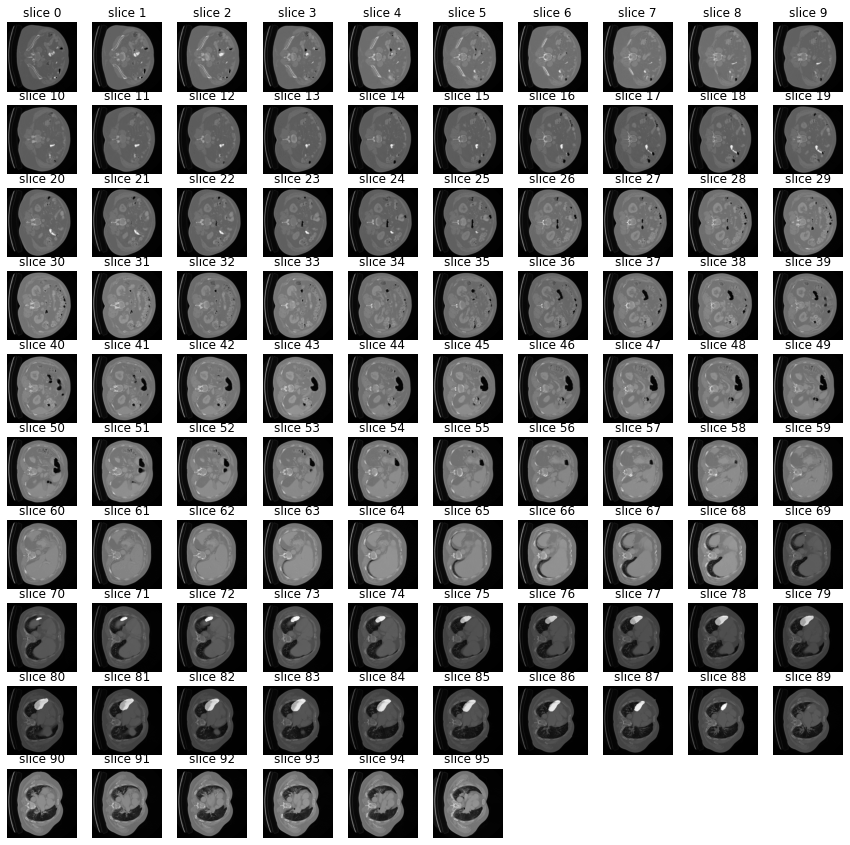

In [ ]:
# Evaluate model performance by plotting predicted labels
def model_predict(model, sample):
    #if torch.is_tensor(sample['image']):
        #image = sample['image'].to(device)
    #else:
        #image = torch.from_numpy(sample['image']).to(device)
    image = torch.from_numpy(data['image']).unsqueeze(0).unsqueeze(0).to(device)
    label = torch.from_numpy(data['label']).long()
    #label =  torch.from_numpy(sample['label']).to(device)

    pred = model(image).squeeze(0).cpu().detach()
    #pred = np.squeeze(pred.cpu().detach())
    pred_label = torch.argmax(pred, dim=0).cpu().detach().numpy()

    return pred_label

sample = dataloader['test'].dataset[4]
pred_label = model_predict(model, sample)
show_slices(sample['image'], pred_label, 10, 10)  

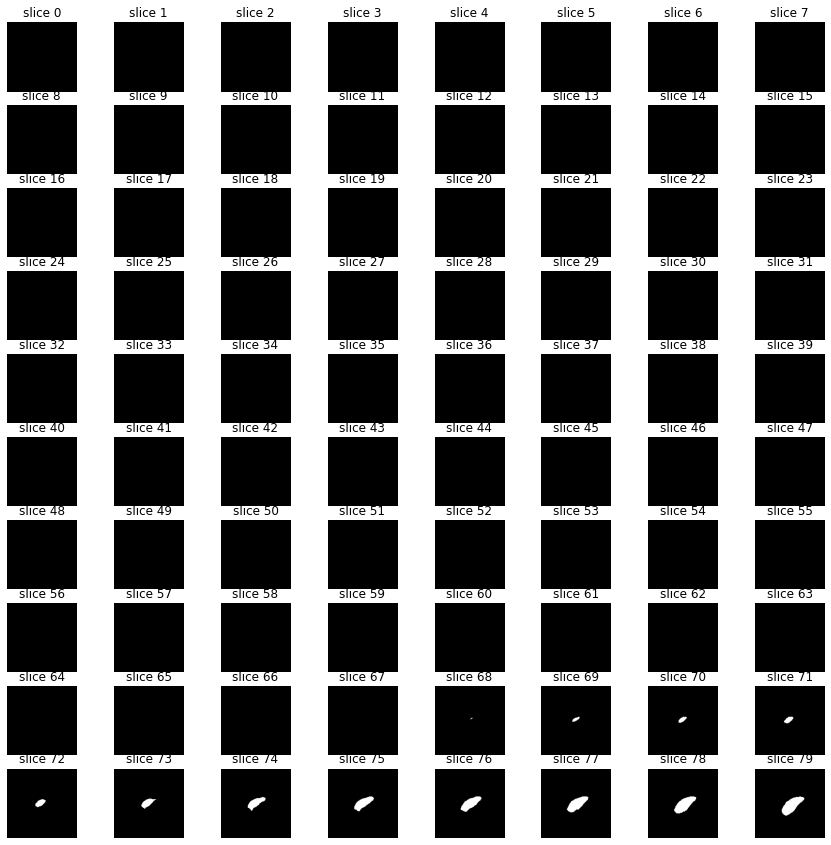

In [ ]:
# There was a model able to make good predictions, but the result could not be reproduced.
image = dataloader['test'].dataset[-1]['image']

show_slices(0*image, pred_label, 8, 10)

In [ ]:
# Test dataset without labels
test_dataset = CTDataset(filepath, data_file='dataset.json', mode='test')

In [ ]:
# Plots of predicted mask of one CT volume from test data
sample = test_data[1]
pred_label = model_predict(model, sample)
show_slices(0*sample['image'], pred_label, 10, 10) 

TypeError: ignored

# Documentation

This section is for you to document your workflow and for us to see that you really understand and know what you do. 
The documentation outline is like a short paper about an experiment. First, write in the introduction what your experiment is about and what people currently use to solve the task. Then in the model section describe WHICH model you use to solve the task, HOW it is designed and WHY you choosed to use it. In the experiments and results section describe HOW your experiment is set up (training hyperparameters, training time, epochs, data set splits) and what results your model achieved in your evaluation. In the conclusion section subsume your work in a short paragraph and maybe state some ideas on how the the model could be improved in future work.

The documentation should NOT exceed 4 pages.

### Introduction

This small project aims to present the pipeline for the segmentation of spleen from CT scans. The data contain 61 CT volumes and are available from the Medical Segmentation Decathlon website [1]. The goal is to train and evaluate a deep learning model for the task of spleen segmentation from CT scans. 

There have been many applications of deep learning to medical image segmentation over the past few years. Convolutional neural networks with different architectures are mostly used, for their efficiency in dealing with vision tasks. Based on the way of image processing, the networks can be classified as 2D, 2.5D and 3D CNNs. For a 2D CNN, CT scans are fed into the network slice by slice while a 3D CNN directly processes the CT volumes. 2.5D approach has better computing efficiency than 3D approach, and captures more spatial information of neighboring pixels than its 2D counterpart by extracting three orthogonal 2D patches from the axial, sagittal and coronal planes [2]. Compared to typical CNNs with fully-connected layers at the end, fully-convolutional network (FCN) has fully convolutional layers, allownig pixel-wise prediction from full-size image rather than patches, and therefore is suitable for segmentation tasks [3]. U-Net [4] is a popular variant of FCN proposed specifically for 2D medical image segmentation. The architecture of a U-Net has a contracting path for context extraction and a expanding path that combines the features from the contracting path to enable localization. To address the tasks of 3D image segmentation, some researchers built on the idea of U-Net and developed other similar network architectures, such as 3D U-Net [5] and V-Net [6].

In this project, the U-Net is used to train the spleen dataset for segmentation. The challenges lie mainly in the dataset, including the small size, the high dynamic range of the CT scans, and a large proportion of background (class imbalance). The details of the model and the strategies for the challenges are described in the next sections.  

### Model

The U-Net [4] is used as the model to train the dataset for segmentation. The network architecture has a contracting path and an expansive path, forming a U shape. The contracting path contains four consecutive encodings, each has two 3x3 convolutions, a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2 for downsampling. There are 32 feature maps in the first encoding step, and the number is doubled at each step. To restore the image resolution, the expansive path has four decoding steps, each has an upsampling of the feature map followed by 2x2 deconvolution that halves the number of feature maps. The upsampled feature maps are concatenated with those from the contracting path, followed by two 3x3 convolutions and ReLU. The contracting path extracts the "What" information from the input image while the expansive path restores the "Where" information through the feature map concatenation. 

As U-Net was designed for medical image segmentation with the characteristics of learning localized features and can be adapted to different number of classes, it is a good choice for this project of spleen segmentation from CT scans. Another advantage is, since the U-Net has no fully connected layers, it is input size agnostic, i.e. there is no limitation on the input image resolution. Here a 3D U-Net is used to for training, allowing direct processing of the CT volumes. The number of feature maps of the model is a hyperparameter that has to be considered and adjusted for the training.

| U-Net | # feature maps | Trainable weights | # Conv layers | 
| :-: | :-: | :-: | :-: |
| 3D | 16 | 4808917 | 23 |

### Experiments and Results
* Dataset

The spleen dataset (available from [1]) consists of 61 portal venous phase CT scans from patients undergoing chemotherapy treatment for liver metastases at Memorial Sloan Kettering Cancer Center (New York, NY, USA) [7]. The given training dataset (imagesTr/\*.nii.gz) contains 41 training samples, each is a  CT volume having a resolution of 521 by 512 and a depth (slices) in the range between 31 and 168. Each slice shows an cross section of the upper body in axial plane, with the left-side body on the top of the image. Each sample has the corresponding annotated ground truth segmentation masks (labelsTr/\*.nii.gz) with labels of spleen (1) and background (0). The spleen annotations appear in 10 to 60 percent of the slices of the samples, and are always on the top of the annotated masks. Since the given test dataset (imagesTs/\*.nii.gz) is not annotated, it cannot be quantitatively evaluated. Thus, the given training dataset (imagesTr/) is split into training, validation and test set, with a 70/15/15 ratio, so that the model can be evaluated on the test set. The model performance on the the given test dataset (imagesTs/) is visually assessed by plotting the predicted segmentation.

| Dataset | Training | Validation | Test | Test w/o lables | 
| :-: | :-: | :-: | :-: | :-: |
| # CT volumes | 24 | 8  | 9 | 20 |

The preprocessing steps include normalization, resizing and cropping for the purpose of better training performance. The original images (CT scans) have pixel values in the range of Hounsfield scale (around -1000 to 3000), so normalization is applied to the images for on a slice-by-slice basis, resulting in a pixel range [0, 1] within each slice. To reduce the memory usage and balance the dataset with mostly the background, the images are resized to a resolution of 256 x 256 and cropped on the top, resulting in a final resolution of 128 x 128. Since the data samples have different number of slices, the padding or trimming is applied to the images and labels to make sure that each has the same depth of 96. As the spleen appears mostly in the deeper slices of the images, deeper images (more slices than the specified number) are trimmeded from the top while shallower images are appended zeros at the top. Therefore, many images may have no information or annotation in the first few slices. 

* Experiement

The experiment was run on Google Colab, with an Intel(R) Xeon(R) CPU working at 2.20GHz, 12 GB RAM and a 16 GB Tesla T4 GPU. The implementation was realized in Python and PyTorch framework. The dataset was stored on Google Drive.  

The model was trained end-to-end on the dataset of abdominal CT scans with spleen annotations. All the volumes had a size of 256 x 256 x 96 voxels. The table below shows the hyperparameters for the model training. The learning rate was initialized with a value of 0.0001, and was decreased for every 10 epochs with a ratio of 0.1. Adam optimizer was used for updating the model parameters for its efficiency and wide usage in deep learning tasks. A Dice loss function was adopted. A batch size of 2 was selected for faster training; besides, the dataset is small.   

| Epoch | Learning rate | Batch size | Optimization | Loss function | 
| :-: | :-: | :-: | :-: | :-: |
| 200 | 0.0001 | 2  | Adam | Dice Loss |

* Experiments and evaluations





### References

[1] http://medicaldecathlon.com/

[2] Hesamian, MH, et al. "Deep learning techniques for medical image segmentation: achievements and challenges." Journal of digital imaging 32.4, pp 582-596, 2019.

[3]  Long J, Shelhamer E, Darrell T. "Fully convolutional networks for semantic segmentation." In: Proceedings of the IEEE Conference
on Computer Vision and Pattern Recognition, pp 3431–3440, 2015.

[4]  Ronneberger O, Fischer P, Brox T. "U-net: convolutional
networks for biomedical image segmentation." In: International
Conference on Medical Image Computing and Computer-Assisted
Intervention. Springer, pp 234–241, 2015.

[5] Çiçek, Ö, Abdulkadir A, Lienkamp SS, Brox T, Ronneberger
O. "3D U-Net: learning dense volumetric segmentation from
sparse annotation. In: International Conference on Medical Image
Computing and Computer-Assisted Intervention." Springer, 
pp 424–432, 2016.

[6] Milletari F, Navab N, Ahmadi SA. "V-net: fully convolutional
neural networks for volumetric medical image segmentation." In:
2016 Fourth International Conference on 3D Vision (3DV). IEEE,
pp 565–571, 2016.

[7] Simpson, A. L. et al. "Chemotherapy-Induced Splenic Volume Increase Is Independently Associated with Major Complications after Hepatic Resection for Metastatic Colorectal Cancer." Journal of the American College of Surgeons 220, 271–280, 2015.